In [1]:
import matplotlib.pyplot as plt
import seaborn as sns 
import scipy.stats as sps
import scipy.special
import scipy.integrate as integrate
from statsmodels.stats.proportion import proportion_confint
import numpy as np
import random
import math
import time
from tqdm import tqdm

## Tasks 1

Функция генерации выборки с первой практики

In [2]:
def generate_n_random_numbers(N: int, distribution: str):
    """
    N - size of sample
    distribution - ["Uniform[0, 1]", "Uniform[-1, 1]", "2xUniform[-1, 1]", "3xUniform[-1, 1]", "Cauchy(0, 1)", Norm(0, 1)]
    """
    match distribution:
        case "Uniform[0, 1]":
            return [random.uniform(0, 1) for _ in range(N)]
        case "Uniform[-1, 1]":
            return [random.uniform(0, 1) * 2 - 1 for _ in range(N)]
        case "2xUniform[-1, 1]":
            t = generate_n_random_numbers(2 * N, "Uniform[-1, 1]")
            return [t[2 * i] + t[2 * i + 1] for i in range(N)]
        case "3xUniform[-1, 1]":
            t = generate_n_random_numbers(3 * N, "Uniform[-1, 1]")
            return [t[3 * i] + t[3 * i + 1] + t[3 * i + 2] for i in range(N)]
        case "Cauchy(0, 1)":
            t = generate_n_random_numbers(N, "Uniform[0, 1]")
            return list(map(lambda x: math.tan(math.pi * (x - 0.5)), t))
        case "Norm(0, 1)":
            return [random.normalvariate(0, 1) for _ in range(N)]
        case _:
            return []

In [25]:
P = 0.95
PERCENTILE = ((1 - P) / 2) * 100
norm_quantile = sps.norm(loc=0, scale=1).ppf((1 + P) / 2)
ANALYTICAL_EXPECTATION = 0
ANALYTICAL_MEDIAN = 0
ITERATIONS = 10 ** 3
BOOTSTRAP_SIZE = 1000
# NS = [10, 100, 500]
min_sample_size = 50
max_sample_size = 500
num_of_sample_sizes = 4
NS = list(map(int, np.logspace(base=5, start=math.log(min_sample_size, 5), stop=math.log(max_sample_size, 5), num=num_of_sample_sizes)))
print(NS)

[50, 107, 232, 500]


Функции подсчёта доверительного интервала для квантили (или медианы при $p=0,5$) точно (через формулу Бернулли) и приближённо (по локальной теореме Муавра-Лапласа)

In [4]:
def bernoulli_coef(n: int, m: int, p: float) -> float:
    return sps.binom.pmf(m, n, p)

def quantil_confidence_interval_exact(sample: list, p=0.5) -> tuple:
    sample = sorted(sample)
    n = len(sample)
    prob = (1 - P) / 2
    m_1 = 0
    cum_sum_1 = bernoulli_coef(n, 0, p)
    while True:
        next_coef = bernoulli_coef(n, m_1 + 1, p)
        if cum_sum_1 + next_coef > prob:
            break
        cum_sum_1 += next_coef
        m_1 += 1
    m_2 = n
    cum_sum_2 = bernoulli_coef(n, n, p)
    while True:
        next_coef = bernoulli_coef(n, m_2 - 1, p)
        if cum_sum_2 + next_coef > prob:
            break
        cum_sum_2 += next_coef
        m_2 -= 1
    return (sample[min(max(m_1, 0), n - 1)], sample[min(max(m_2, 0), n - 1)])
    

In [5]:
def quantil_confidence_interval_approx(sample: list, p=0.5) -> tuple:
    sample = sorted(sample)
    n = len(sample)
    term = math.sqrt(n * p * (1 - p)) * norm_quantile
    return (sample[min(max(math.floor(n * p - term), 0), n - 1)], sample[min(max(math.ceil(n * p + term), 0), n - 1)])

Сгенерируем по $10^4$ выборок разных размеров для каждого распределения и проверим, какая доля из них будет попадать в доверительный интервал для медианы, посчитав доверительный интервал для этой доли

In [6]:
distros = ["Uniform[-1, 1]", "Norm(0, 1)", "2xUniform[-1, 1]"]
methods = ["exact", "approx"]
NUM_METHODS = len(methods)
methods_functions = {"exact": quantil_confidence_interval_exact, "approx": quantil_confidence_interval_approx}
sigma_squared = {"Uniform[-1, 1]": 1 / 3,
                 "Norm(0, 1)": 1,
                 "2xUniform[-1, 1]": 2 / 3}

In [26]:
print("Start generating samples...")
samples = {d: [[generate_n_random_numbers(n, d) for _ in range(ITERATIONS)]
                for n in NS] for d in tqdm(distros)}
print("Samples generated.")

Start generating samples...


100%|██████████| 3/3 [00:01<00:00,  2.08it/s]

Samples generated.


In [8]:
# results = {d: {"exact_intervals": [], "exact_points": [], "approx_intervals": [], "approx_points": []} for d in distros}
# total_time = {m: 0 for m in methods}
# for i, d in enumerate(distros):
#     results_exact_intervals = []
#     results_exact_points = []
#     results_approx_intervals = []
#     results_approx_points = []
#     for n_id, n in enumerate(NS):
#         print(f"Distribution {d}, samples size = {n}")
#         for method in methods:
#             # print(f"{method.capitalize()}:")
#             hits_counter = 0
#             start_time = time.time()
#             for sample in tqdm(samples[d][n_id]):
#                 d_left, d_right = methods_functions[method](sample)
#                 hits_counter += d_left <= ANALYTICAL_MEDIAN <= d_right
#             total_time[method] += time.time() - start_time
#             results[d][method + "_intervals"].append(proportion_confint(hits_counter, ITERATIONS, alpha=1 - P, method='normal'))
#             results[d][method + "_points"].append(hits_counter / ITERATIONS)

#     print(f"Results for distribution {d}\n"
#             f"{results[d]['exact_intervals']} (exact)\n"
#             f"{results[d]['approx_intervals']} (approx)\n")
    
# print(f"Exact method took {total_time['exact']:.2f} seconds, approximate method took {total_time['approx']:.2f} seconds")


In [9]:
# _, axis = plt.subplots(3, NUM_METHODS, figsize=(5 * NUM_METHODS, 4 * len(distros)))
# for i, d in enumerate(distros):
#     for method_id, method in enumerate(methods):
#         for interval_id, interval in enumerate(results[d][method + "_intervals"]):
#             axis[i][method_id].plot([NS[interval_id]] * 2, list(interval), color='C0', alpha=.5, linewidth=1)

#         axis[i][method_id].plot(NS, results[d][method + "_points"], '-o', color='C0', alpha=1)         
#         axis[i][method_id].plot(NS, [0.95] * len(NS), color='gray', alpha=.5, linestyle='--')         
#         axis[i][method_id].set_xscale('log')
#         axis[i][method_id].set_ylim([0.9, 1])
#     axis[i][0].set_ylabel(d)

# axis[0][0].title.set_text("Exact")
# axis[0][1].title.set_text("Approx")
# plt.show()

## Task 2

Теперь сделаем то же самое, но с доверительными интервалами не для медианы, а квантилей $x_{0.01}$ и $x_{0.99}$

In [10]:
QUANTILES = [0.01, 0.99]

Для того чтобы оценить, сколько доверительных интервалов на самом деле содержат реальные квантили, нужно их сначала найти для наших распределений. 

Это легко сделать для стандартных распределений $\text{Uniform}[-1, 1]$ и $\text{Norm}(0, 1)$, но несколько сложнее для $2\cdot\text{Uniform}[-1, 1]$. Для первых двух воспользуемся стандартной функцией, а для последнего напишем бинпоиск по функции распределения, поскольку она монотонна. Чтобы найти функцию распределения, проинтегрируем свёртку плотностей равномерных распределений, то есть
$$\xi, \eta \sim \text{Uniform[-1, 1]}$$
$$F_{\xi + \eta}(t) = \int_{-\infty}^t p_{\xi + \eta}(x) dx = \int_{-\infty}^t \int_{\mathbb{R}} p_\xi(y)\cdot p_\eta(x-y)dy dx$$
Внутренний интеграл легко посчитать и аналитически записать полученную функцию. Итого можем посчитать функцию распределения суммы двух равномерных распределений:

In [11]:
def sum_pdf(t: float) -> float:
    if t <= -2 or t >= 2:
        return 0
    if -2 < t <= 0:
        return (2 + t) / 4
    return (2 - t) / 4

def sum_cdf(t):
    return integrate.quad(sum_pdf, -np.inf, t)[0]

def sum_quantile(p, lo=-2, hi=2):
    val_range = [lo, hi]
    k = 0.5 * sum(val_range)
    for _ in range(32):
        val_range[int(sum_cdf(k) > p)] = k
        next_k = 0.5 * sum(val_range)
        if next_k == k:
            break
        k = next_k
    return k

In [12]:
QUANTILE_VALUES = {d: {} for d in distros}
QUANTILE_VALUES["Uniform[-1, 1]"] = {q: sps.uniform.ppf(q, loc=-1, scale=2) for q in QUANTILES}
QUANTILE_VALUES["Norm(0, 1)"] = {q: sps.norm.ppf(q) for q in QUANTILES}
QUANTILE_VALUES["2xUniform[-1, 1]"] = {q: sum_quantile(q) for q in QUANTILES}

Визуализируем для наглядности полученный результат

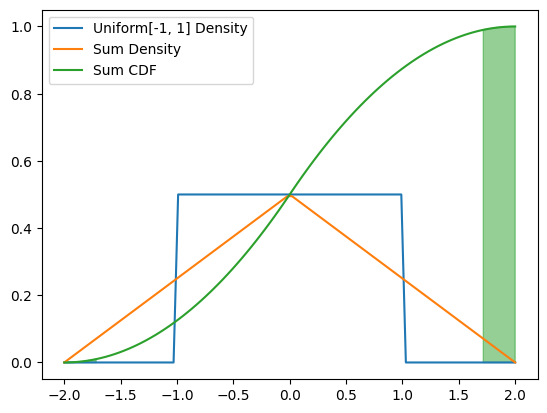

In [13]:
x = np.linspace(-2, 2, 100)
y1 = sps.uniform.pdf(x, loc=-1, scale=2)
y2 = [sum_pdf(t) for t in x]
y3 = [sum_cdf(t) for t in x]
    
plt.plot(x, y1, label='Uniform[-1, 1] Density')
plt.plot(x, y2, label='Sum Density')
plt.plot(x, y3, label='Sum CDF')
plt.fill_between(x, y3, where = (x > QUANTILE_VALUES["2xUniform[-1, 1]"][0.99]) | (x < QUANTILE_VALUES["2xUniform[-1, 1]"][0.01]), color='C2', alpha=0.5)
plt.legend()
plt.show()

In [15]:
print(QUANTILE_VALUES)

{'Uniform[-1, 1]': {0.01: np.float64(-0.98), 0.99: np.float64(0.98)}, 'Norm(0, 1)': {0.01: np.float64(-2.3263478740408408), 0.99: np.float64(2.3263478740408408)}, '2xUniform[-1, 1]': {0.01: -1.7171573103405535, 0.99: 1.7171572870574892}}


Теперь приступим к подсчёту доверительных интервалов для квантилей по нашим выборкам

In [27]:
results = {d: {q: {"exact_intervals": [], "exact_points": [], "approx_intervals": [], "approx_points": []} for q in QUANTILES} for d in distros}
for i, d in enumerate(distros):
    results_exact_intervals = []
    results_exact_points = []
    results_approx_intervals = []
    results_approx_points = []
    for n_id, n in enumerate(NS):
        print(f"Distribution {d}, samples size = {n}")
        for method in methods:
            for p in QUANTILES:
                hits_counter = 0
                start_time = time.time()
                for sample in tqdm(samples[d][n_id]):
                    d_left, d_right = methods_functions[method](sample=sample, p=p)
                    hits_counter += d_left <= QUANTILE_VALUES[d][p] <= d_right
                results[d][p][method + "_intervals"].append(proportion_confint(hits_counter, ITERATIONS, alpha=1 - P, method='normal'))
                results[d][p][method + "_points"].append(hits_counter / ITERATIONS)

Distribution Uniform[-1, 1], samples size = 50


100%|██████████| 1000/1000 [00:00<00:00, 262702.24it/s]


Distribution Uniform[-1, 1], samples size = 107


100%|██████████| 1000/1000 [00:00<00:00, 115967.26it/s]


Distribution Uniform[-1, 1], samples size = 232


100%|██████████| 1000/1000 [00:00<00:00, 59374.92it/s]


Distribution Uniform[-1, 1], samples size = 500


100%|██████████| 1000/1000 [00:00<00:00, 27635.74it/s]


Distribution Norm(0, 1), samples size = 50


100%|██████████| 1000/1000 [00:00<00:00, 277254.36it/s]


Distribution Norm(0, 1), samples size = 107


100%|██████████| 1000/1000 [00:00<00:00, 126080.02it/s]


Distribution Norm(0, 1), samples size = 232


100%|██████████| 1000/1000 [00:00<00:00, 49245.10it/s]


Distribution Norm(0, 1), samples size = 500


100%|██████████| 1000/1000 [00:00<00:00, 26548.24it/s]


Distribution 2xUniform[-1, 1], samples size = 50


100%|██████████| 1000/1000 [00:00<00:00, 250780.51it/s]


Distribution 2xUniform[-1, 1], samples size = 107


100%|██████████| 1000/1000 [00:00<00:00, 110237.17it/s]


Distribution 2xUniform[-1, 1], samples size = 232


100%|██████████| 1000/1000 [00:00<00:00, 58420.56it/s]


Distribution 2xUniform[-1, 1], samples size = 500


100%|██████████| 1000/1000 [00:00<00:00, 27206.77it/s]


In [28]:
quantil_to_color = {q: "C" + str(q_id) for q_id, q in enumerate(QUANTILES)}

In [29]:
results

{'Uniform[-1, 1]': {0.01: {'exact_intervals': [(0.3706237828676462,
     0.43137621713235386),
    (0.6326819260543393, 0.6913180739456608),
    (0.8706072482987598, 0.9093927517012402),
    (0.9825353862829762, 0.9954646137170238)],
   'exact_points': [np.float64(0.401),
    np.float64(0.662),
    np.float64(0.89),
    np.float64(0.989)],
   'approx_intervals': [(0.35779772449422487, 0.41820227550577516),
    (0.6326819260543393, 0.6913180739456608),
    (0.8598590454182207, 0.9001409545817793),
    (0.9762231158120357, 0.9917768841879643)],
   'approx_points': [np.float64(0.388),
    np.float64(0.662),
    np.float64(0.88),
    np.float64(0.984)]},
  0.99: {'exact_intervals': [(0.3469625687736909, 0.4070374312263091),
    (0.5868706293564394, 0.6471293706435606),
    (0.8966231755161699, 0.9313768244838302),
    (0.9689086399264986, 0.9870913600735014)],
   'exact_points': [np.float64(0.377),
    np.float64(0.617),
    np.float64(0.914),
    np.float64(0.978)],
   'approx_intervals':

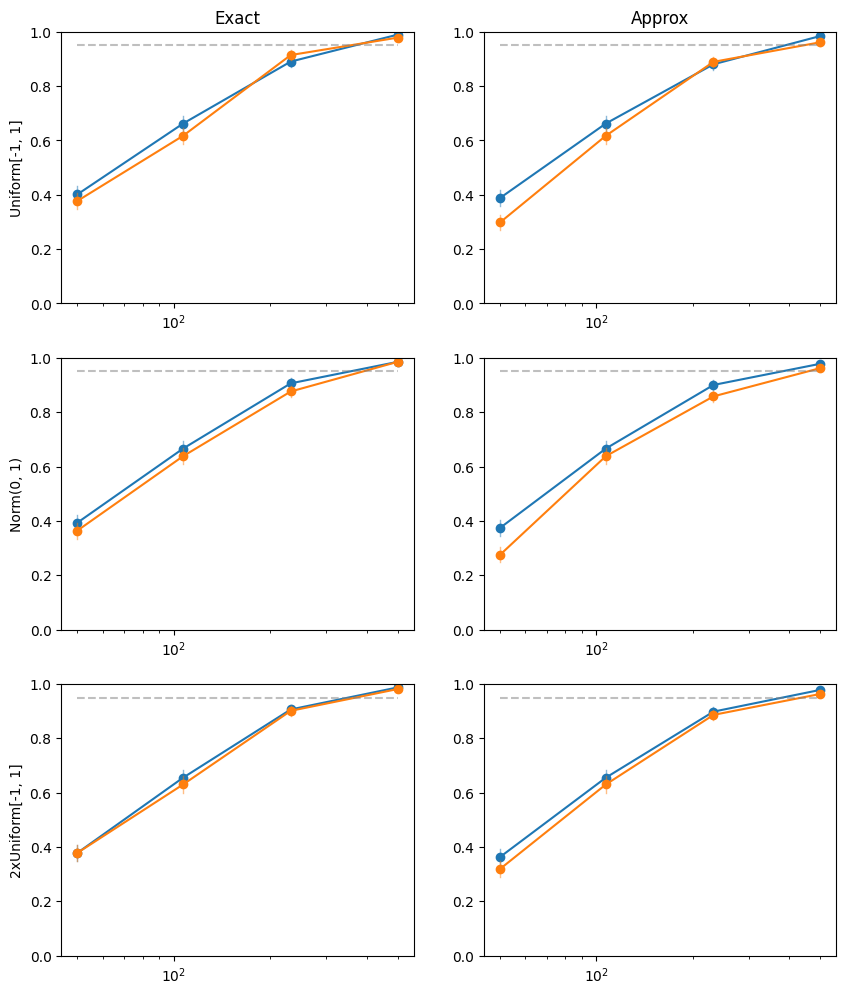

In [30]:
_, axis = plt.subplots(3, NUM_METHODS, figsize=(5 * NUM_METHODS, 4 * len(distros)))
for i, d in enumerate(distros):
    for method_id, method in enumerate(methods):
        for q in QUANTILES:
            for interval_id, interval in enumerate(results[d][q][method + "_intervals"]):
                axis[i][method_id].plot([NS[interval_id]] * 2, list(interval), color=quantil_to_color[q], alpha=.5, linewidth=1)

            axis[i][method_id].plot(NS, results[d][q][method + "_points"], '-o', color=quantil_to_color[q], alpha=1)         
        axis[i][method_id].plot(NS, [0.95] * len(NS), color='gray', alpha=.5, linestyle='--')
        axis[i][method_id].set_xscale('log')
        axis[i][method_id].set_ylim([0, 1])
    axis[i][0].set_ylabel(d)

axis[0][0].title.set_text("Exact")
axis[0][1].title.set_text("Approx")
plt.show()